In [ ]:
# Source
# https://colab.research.google.com/github/Psarpei/Multi_Type_TD_TSR/blob/main/Table_Recognition.ipynb#scrollTo=NP4gRIsiH2Gh

## Setup

#### Google Drive

In [1]:
# ONLY for colabs
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
#Create a "downloads" folder 
# save its path
path = "/content/drive/MyDrive/ColabNotebooks/ImageProcessing/Multi-Type-TD-TSR/downloads/"

In [33]:
# ONLY for colabs
%cd {path}


/content/drive/MyDrive/ColabNotebooks/ImageProcessing/Multi-Type-TD-TSR/downloads


#### Install dependencies

In [27]:
# install dependencies: 
!pip install pyyaml==5.1
!pip install torch==1.7
!pip install torchvision==0.8.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions

!sudo apt install tesseract-ocr 
!pip install pytesseract

import torch, torchvision
torch.__version__
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

1.7.0 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


#### Clone repository

In [28]:
!git clone https://github.com/Psarpei/Multi-Type-TD-TSR.git
!mv Multi-Type-TD-TSR/ Multi_Type_TD_TSR

Cloning into 'Multi-Type-TD-TSR'...
remote: Enumerating objects: 263, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (242/242), done.
remote: Total 263 (delta 153), reused 55 (delta 20), pack-reused 0
Receiving objects: 100% (263/263), 17.12 MiB | 13.48 MiB/s, done.
Resolving deltas: 100% (153/153), done.


#### Download Table Detection Weights and Configuration File

In [5]:
!gdown --id 11FgFTy0MyVUMGd00T_InEDaarB4qAlP8
!gdown --id 1WBk6kHHyvyEzoPBsRr2BvFY51zURjd4R
!gdown --id 1PfA2uws919gc893-x9uMIz06zWEko8nF 

Downloading...
From: https://drive.google.com/uc?id=11FgFTy0MyVUMGd00T_InEDaarB4qAlP8
To: /content/drive/MyDrive/ColabNotebooks/ImageProcessing/Multi-Type-TD-TSR/model_final.pth
100% 1.10G/1.10G [00:09<00:00, 110MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WBk6kHHyvyEzoPBsRr2BvFY51zURjd4R
To: /content/drive/My Drive/ColabNotebooks/ImageProcessing/Multi-Type-TD-TSR/All_X152.yaml
100% 534/534 [00:00<00:00, 430kB/s]
Downloading...
From: https://drive.google.com/uc?id=1PfA2uws919gc893-x9uMIz06zWEko8nF
To: /content/drive/My Drive/ColabNotebooks/ImageProcessing/Multi-Type-TD-TSR/Base-RCNN-FPN.yaml
100% 1.36k/1.36k [00:00<00:00, 1.17MB/s]


#### Import everything

In [6]:
import detectron2
import Multi_Type_TD_TSR.google_colab.deskew as deskew
import Multi_Type_TD_TSR.google_colab.table_detection as table_detection
import Multi_Type_TD_TSR.google_colab.table_structure_recognition_all as tsra
import Multi_Type_TD_TSR.google_colab.table_structure_recognition_lines as tsrl
import Multi_Type_TD_TSR.google_colab.table_structure_recognition_wol as tsrwol
import Multi_Type_TD_TSR.google_colab.table_structure_recognition_lines_wol as tsrlwol
import Multi_Type_TD_TSR.google_colab.table_xml as txml
import Multi_Type_TD_TSR.google_colab.table_ocr as tocr
import pandas as pd
import os
import json
import itertools
import random
from detectron2.utils.logger import setup_logger
# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog, MetadataCatalog
from google.colab.patches import cv2_imshow
setup_logger()

<Logger detectron2 (DEBUG)>

## Table detection

#### Initialize detector

In [37]:
#create detectron config
cfg = get_cfg()

# modify "All_X152.yaml"
# replacing 
#_BASE_: /content/Base-RCNN-FPN.yaml 
# with 
# _BASE_: /content/drive/MyDrive/ColabNotebooks/ImageProcessing/Multi-Type-TD-TSR/downloads/Base-RCNN-FPN.yaml

#set yaml
cfg.merge_from_file(path+'/All_X152.yaml')

#set model weights
cfg.MODEL.WEIGHTS = path+'/model_final.pth' # Set path model .pth

predictor = DefaultPredictor(cfg) 

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


### Structured table detection

TABLE DETECTION:


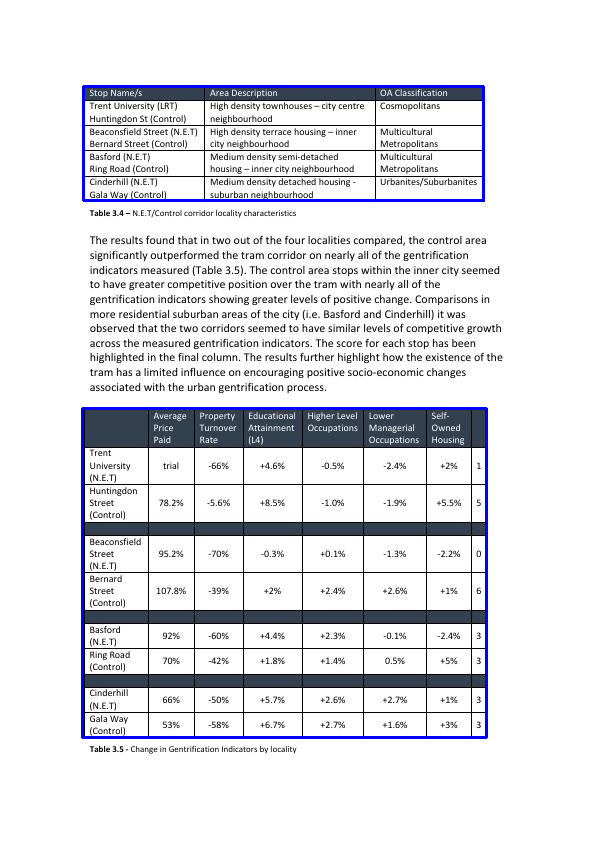

In [38]:
document_img = cv2.imread(path+"/Multi_Type_TD_TSR/images/color_invariance_example.jpg")
table_detection.plot_prediction(document_img, predictor)

#### Table trimming

TABLE 0 :


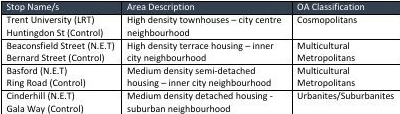


TABLE 1 :


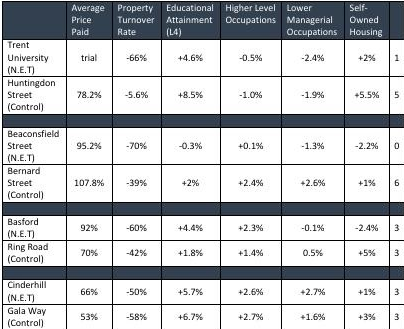

In [19]:
table_list, table_coords = table_detection.make_prediction(document_img, predictor)

#### Structure Detection

In [ ]:
list_table_boxes = []
for table in table_list:
    finalboxes, output_img = tsrlwol.recognize_structure(table)
    list_table_boxes.append(finalboxes)

#### OCR

In [24]:
tocr.output_to_csv(list_table_boxes[1], output_img)

                0        1      2        3       4       5        6   7
0      UnNIVeESIY      mar   -bbv   +4.b0%                       +l   a
1              mr                                                      
2                                                                      
3          sireec     6.24   >.b%       HL                   25.5%)   >
4       \n\nanced                                                      
5                                                                      
6          sireec    33.2%             U.S    411%                     
7              mr                                                      
8                                                                      
9          sireec   10s 2%    “5%      +2%    +24%   22.0%        +   b
10      \n\nanren                                                      
11         tiunen     92%.           +4.4%   92.3%    0.1%    -2.4%   3
12                     yox    42%     +13%     +14     Os%      

### Unstructured Table detection

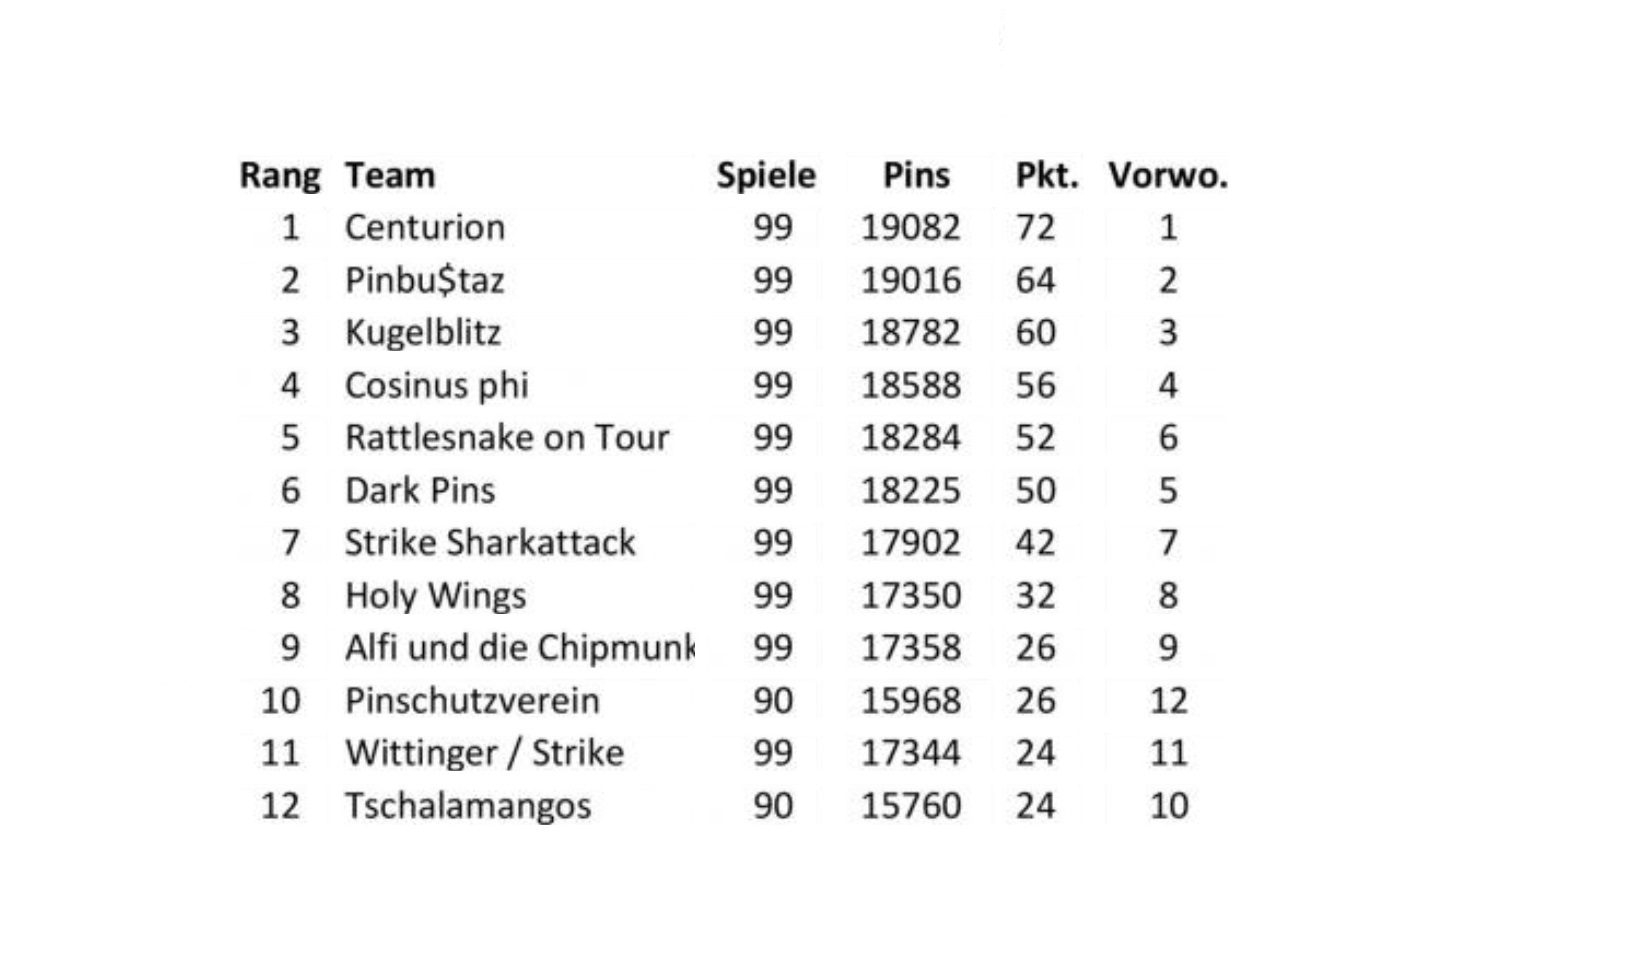

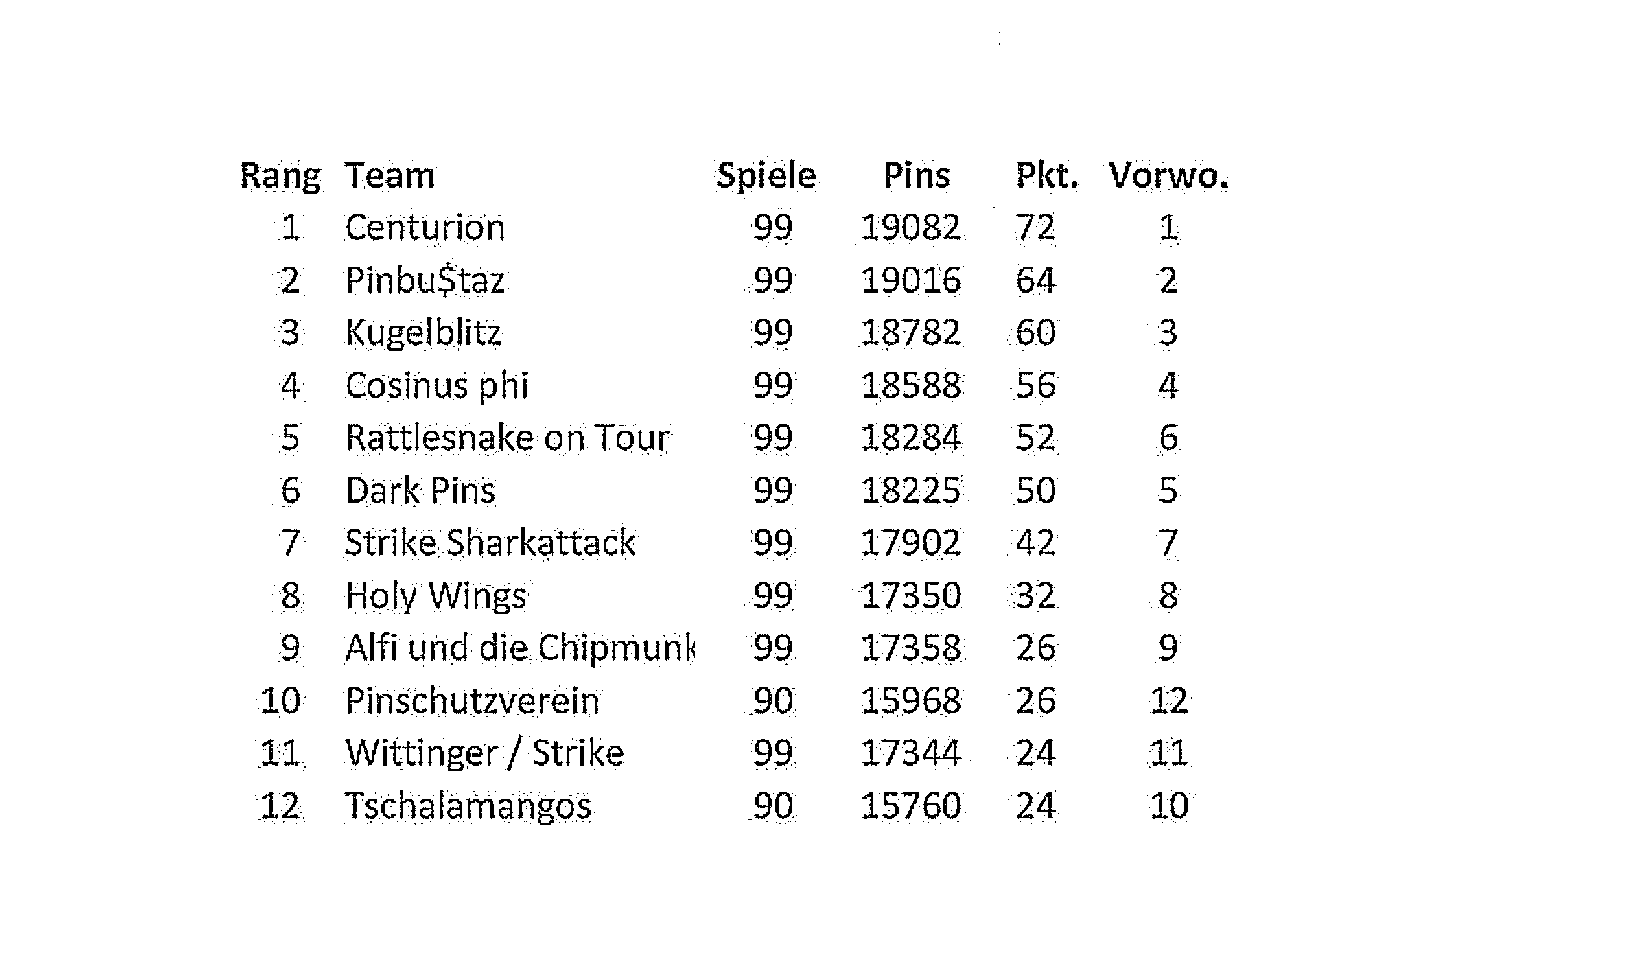

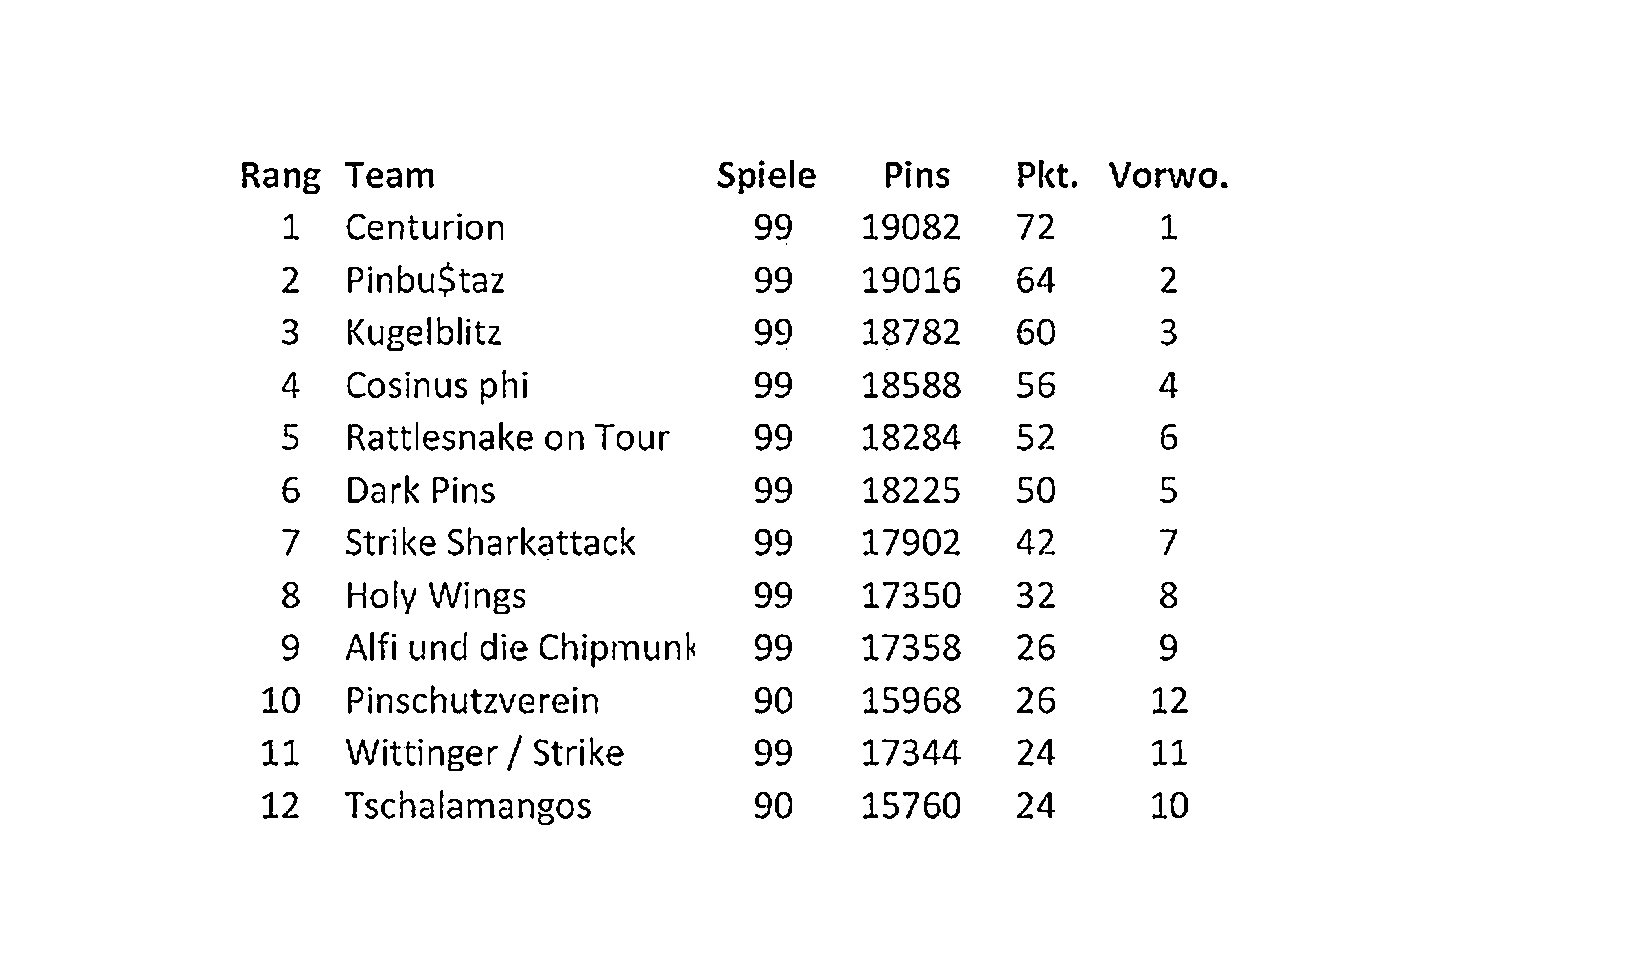

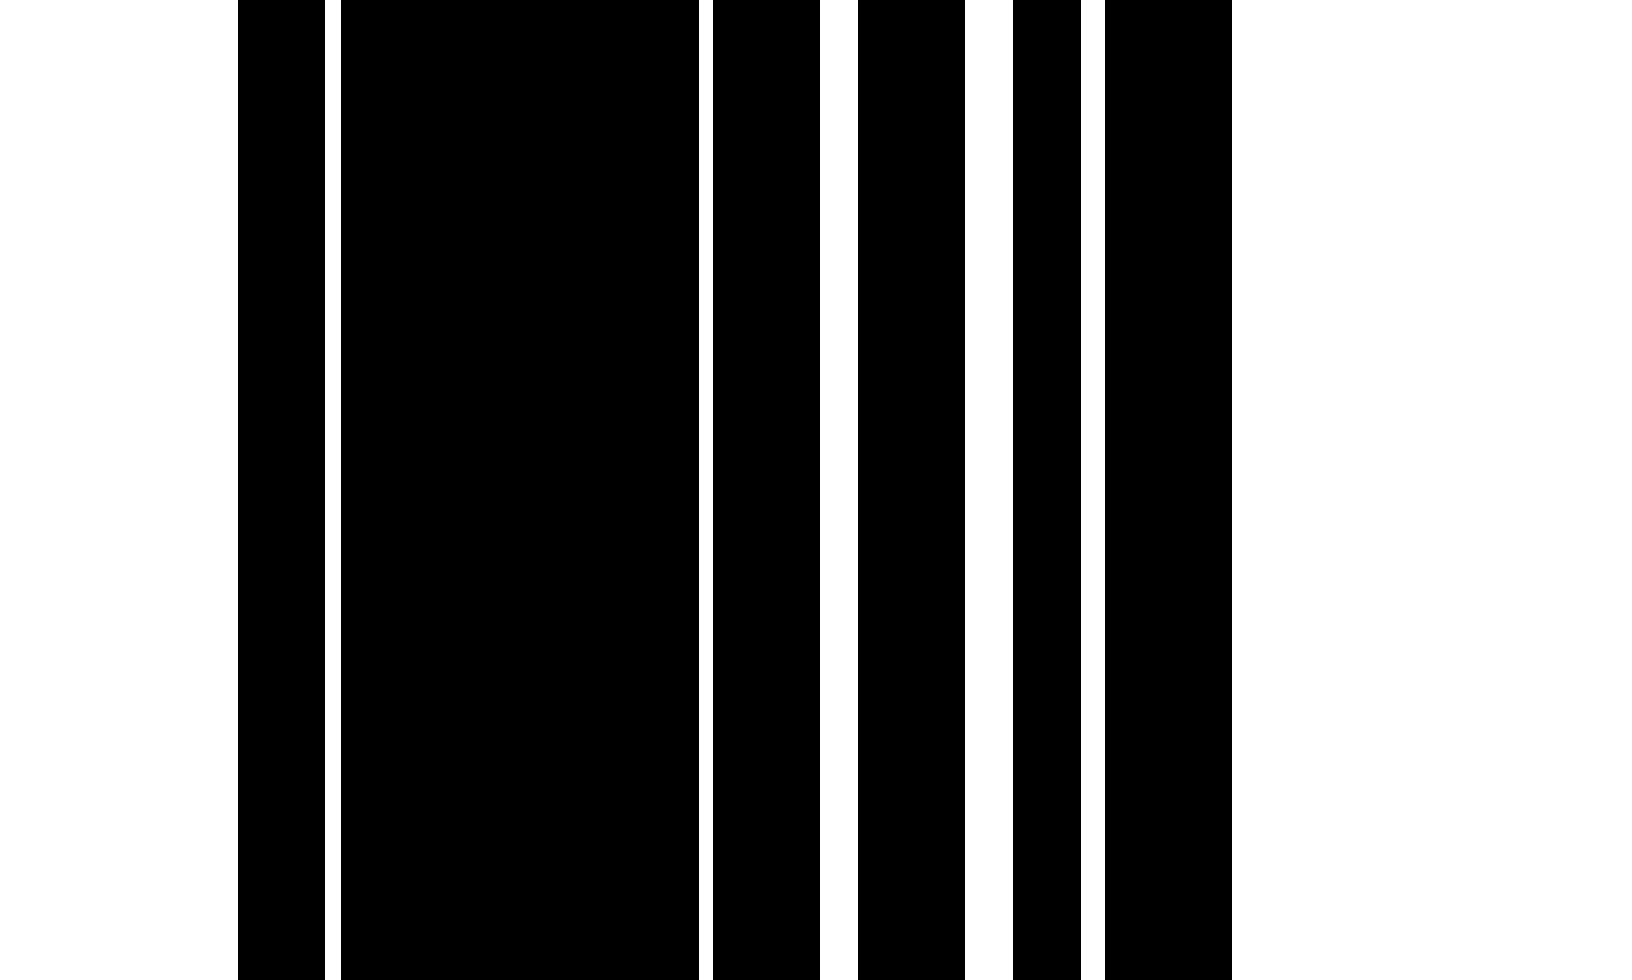

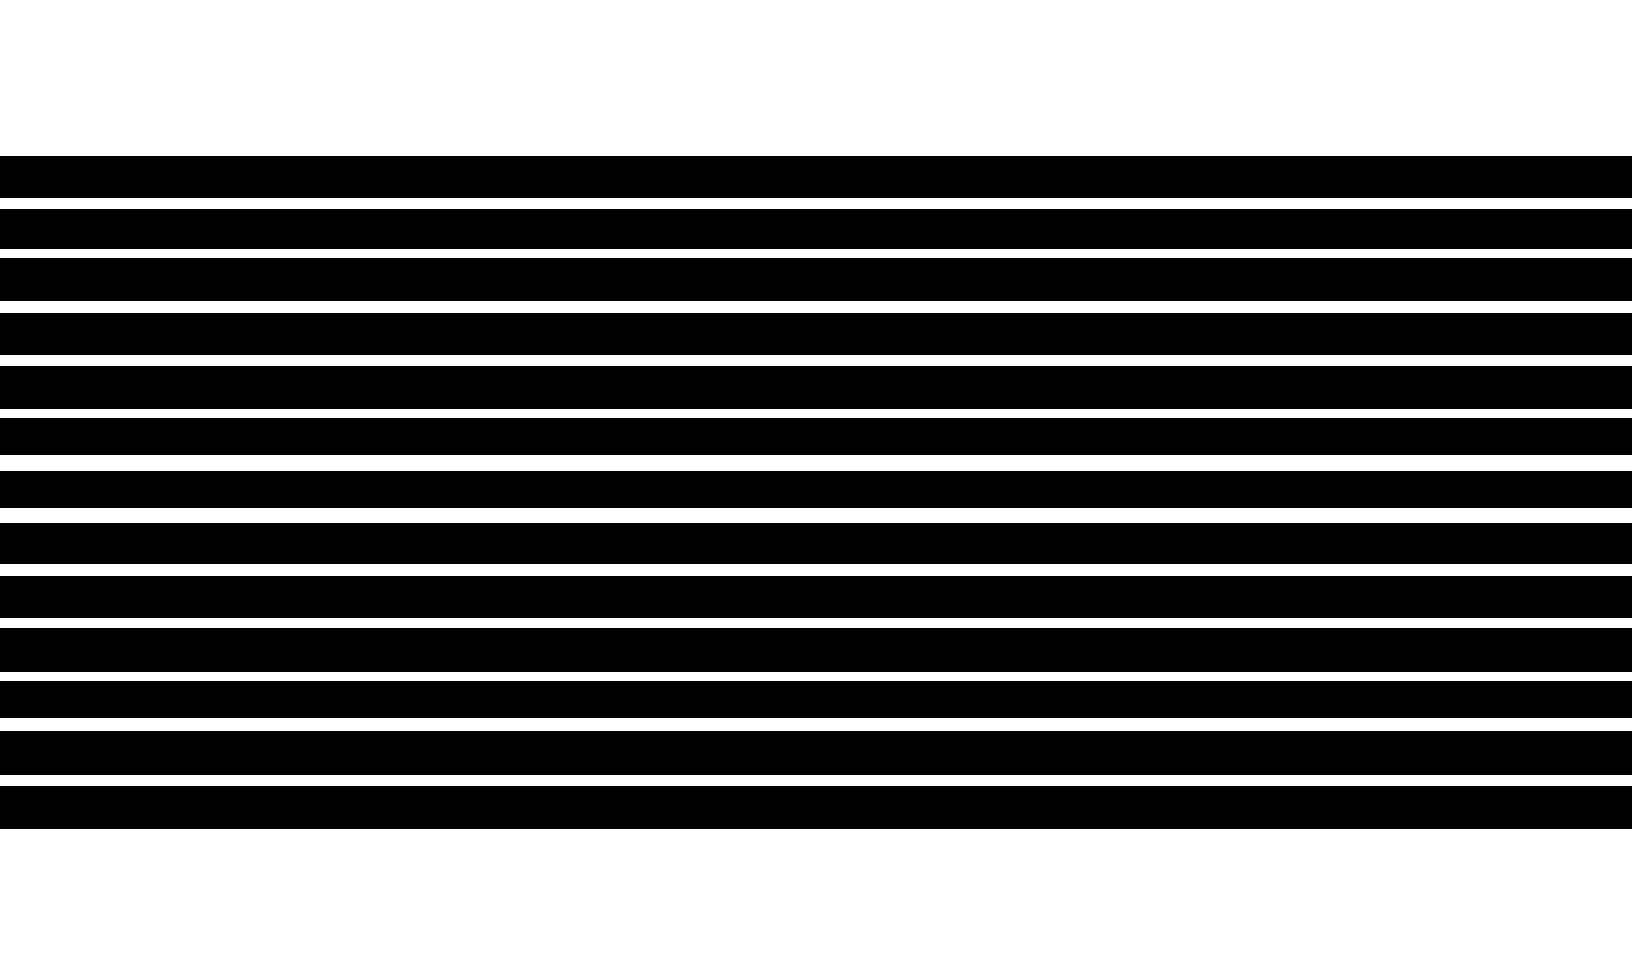

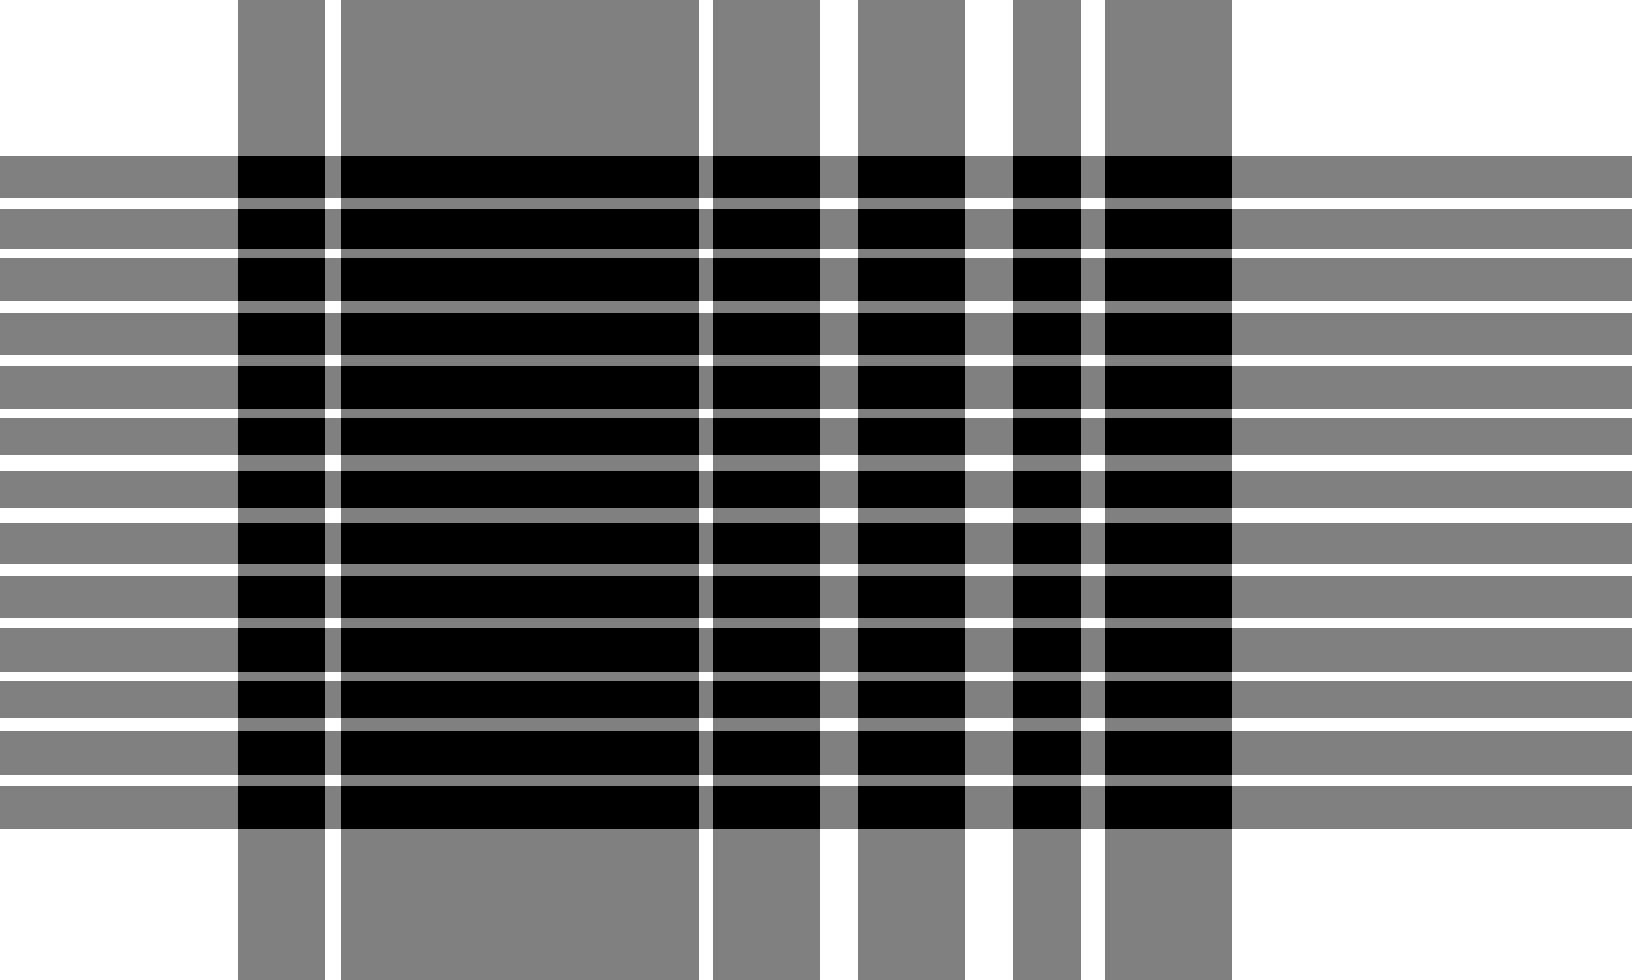

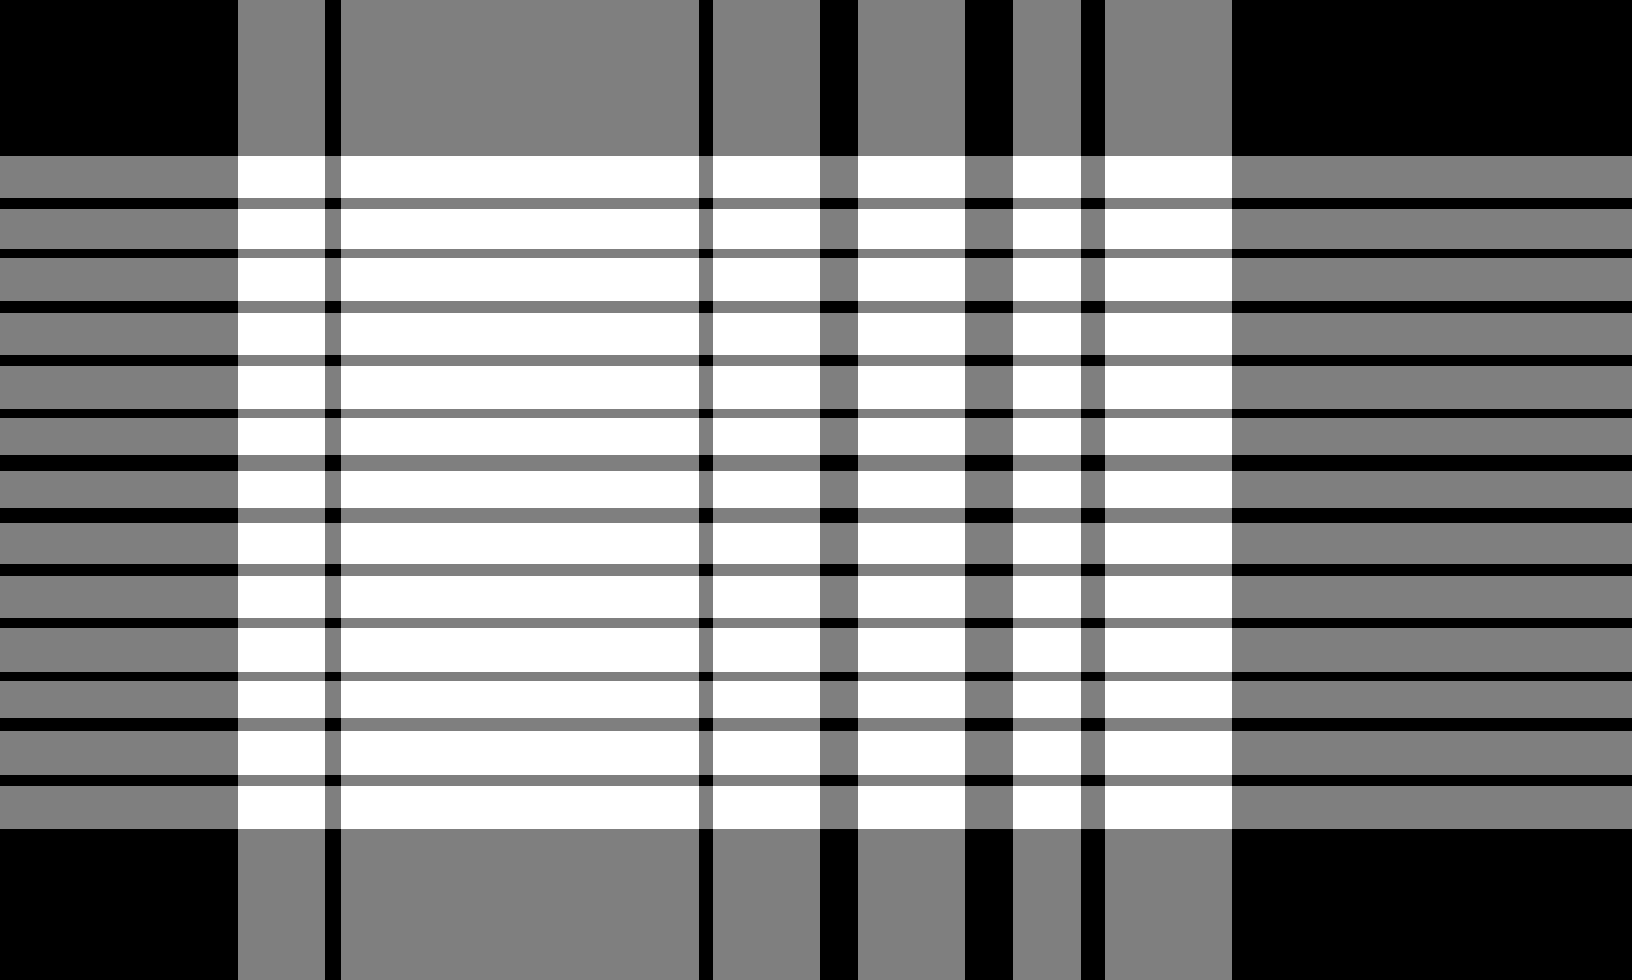

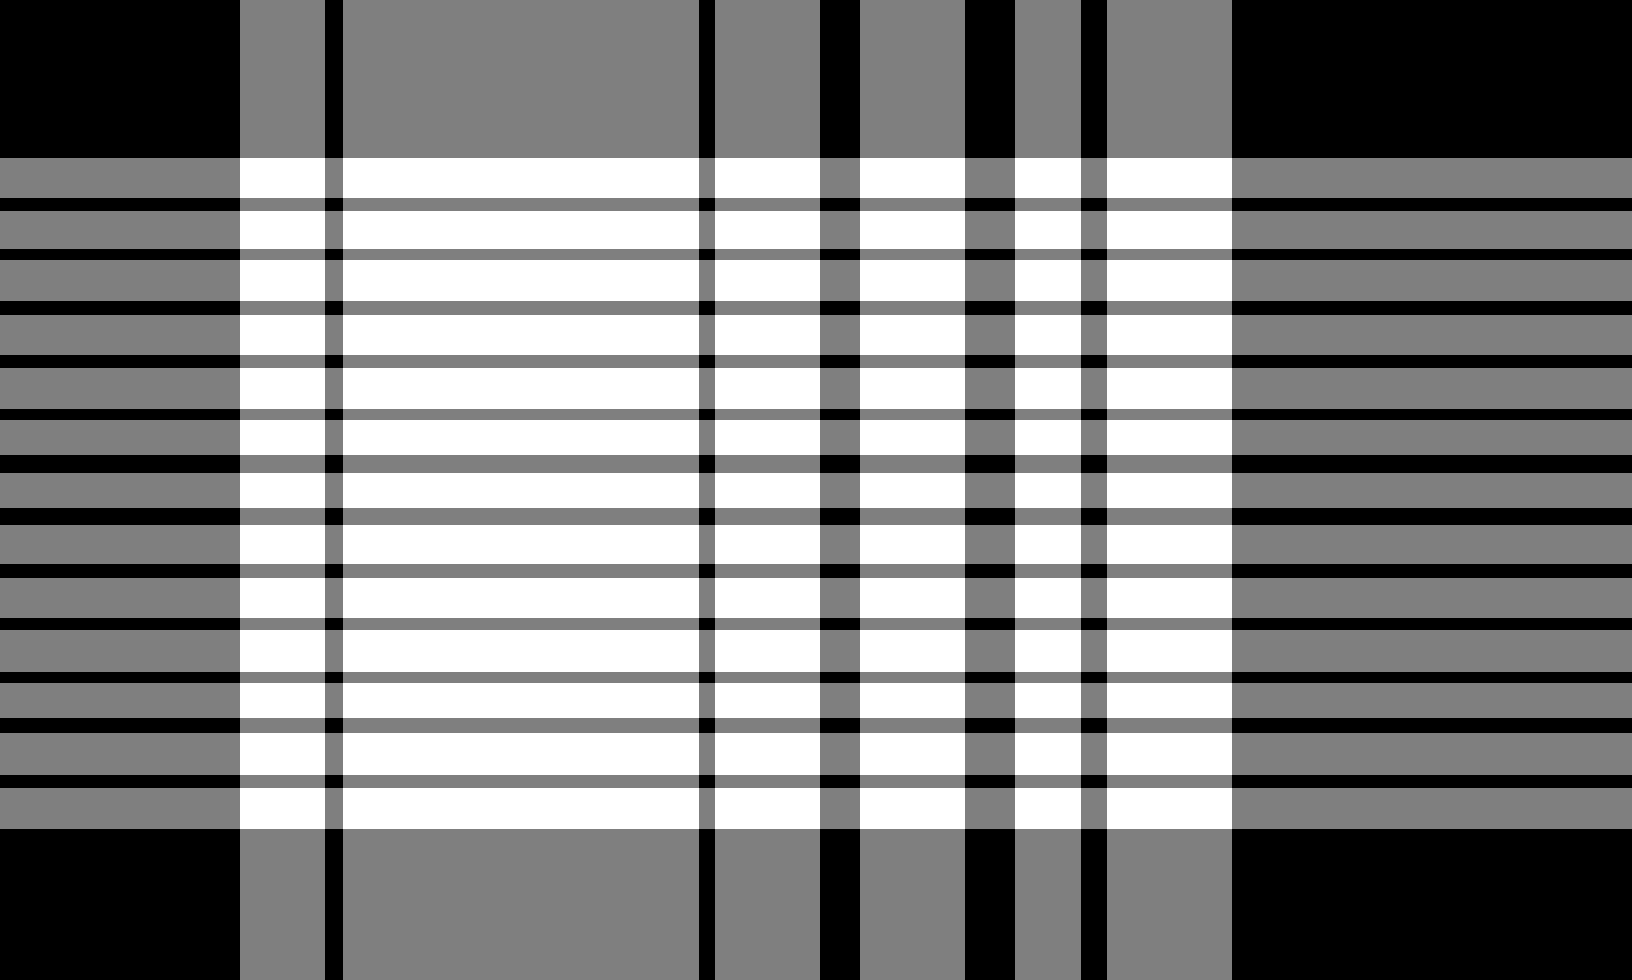

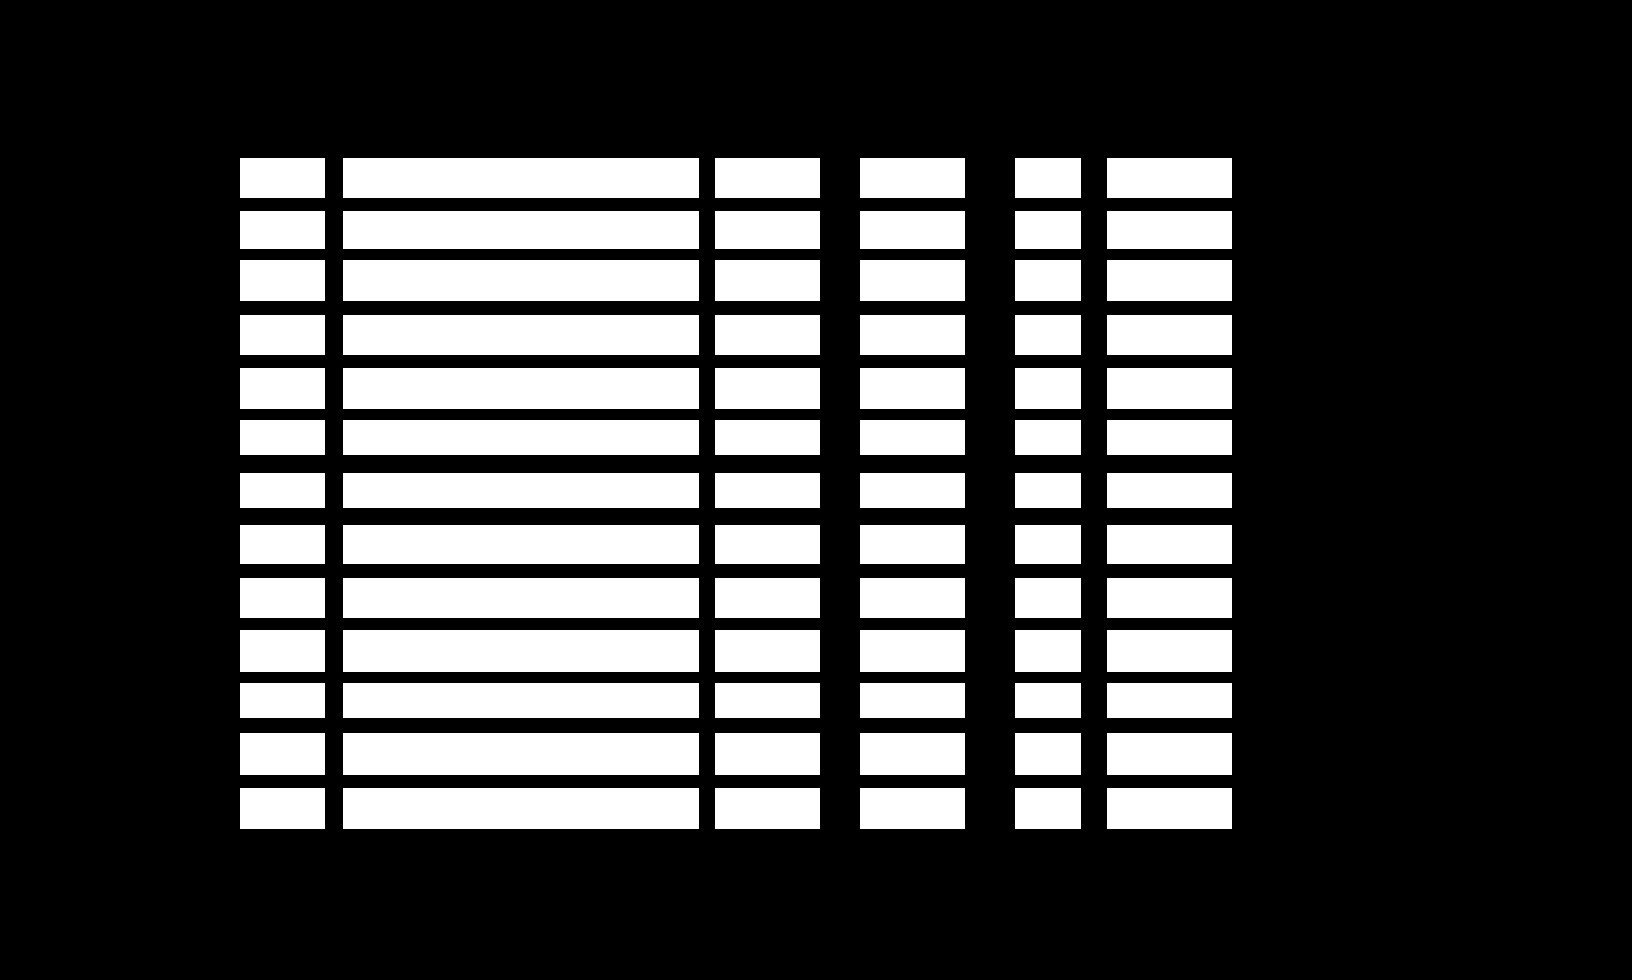

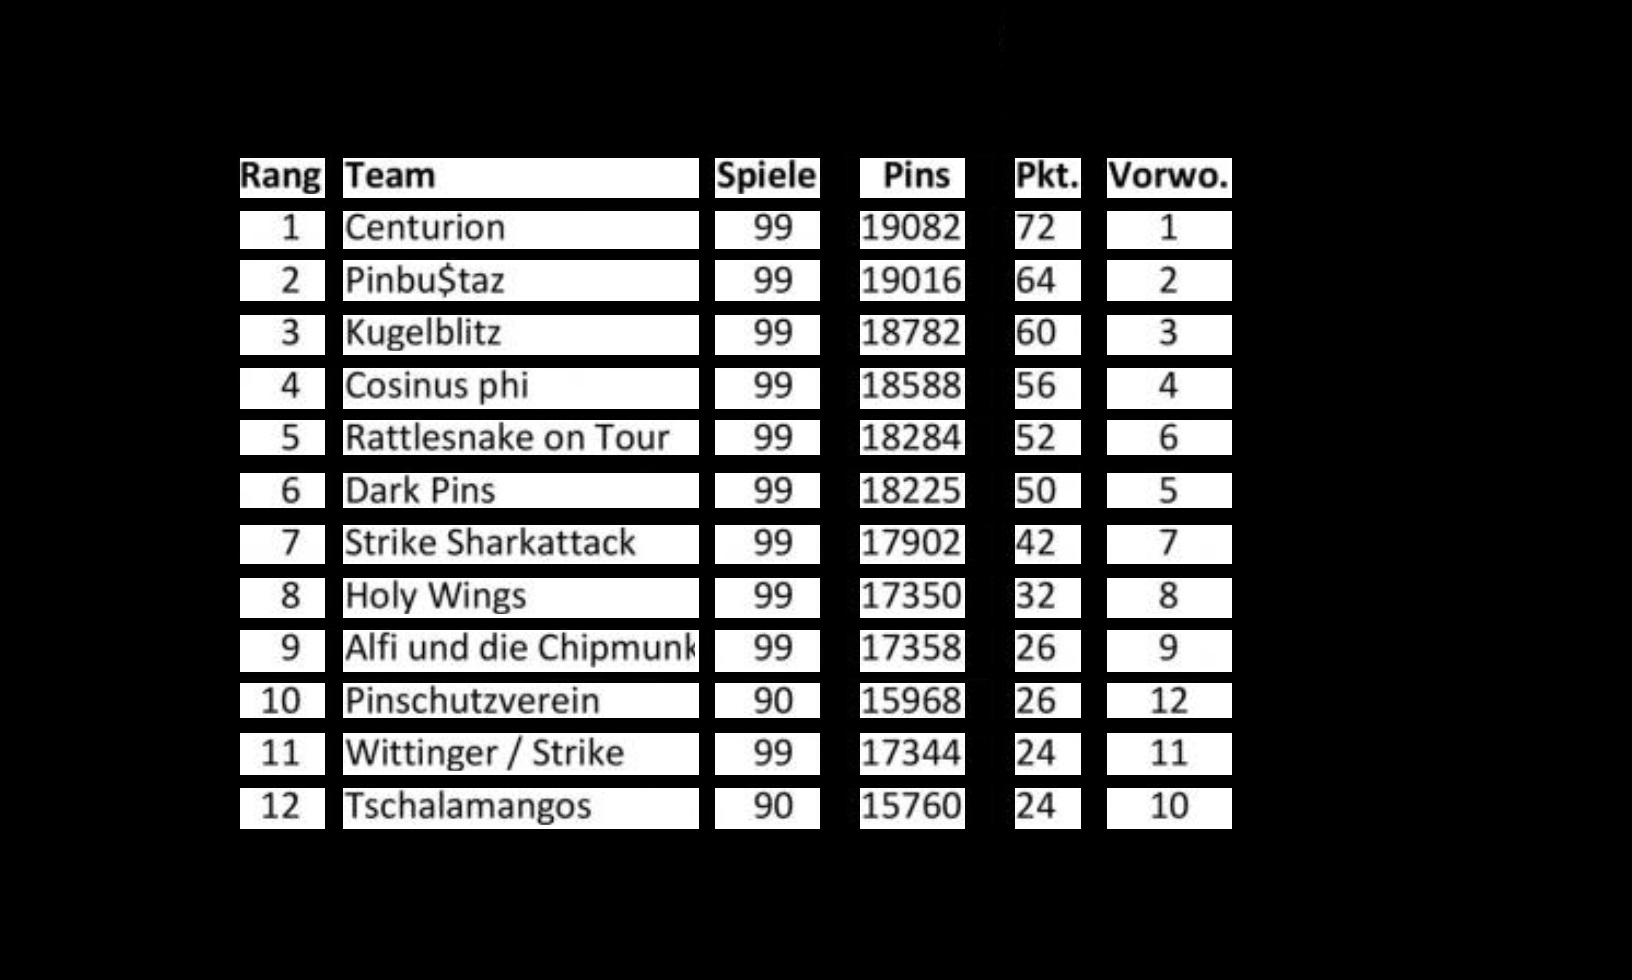

        0                        1        2       3      4    5
0    Rang                     Team   Spiele    Pins   Pkt.     
1                        Centurion                             
2       e                PinbuStaz       99   19016     64    2
3       3               Kugelblitz                      60    3
4       q              Cosinus phi                      56    4
5       5      Rattlesnake on Tour                     52.    6
6       6                Dark Pins                      50    5
7       7                                               Ad    7
8                      Holy Wings:                     32.     
9           Alfi und die. Chipmunk                      26    9
10                 Pinschutzverein                      26     
11               Wittinger/ Strike      99.   17344     24   a1
12                  Tschalamangos.                      24     


In [25]:
unbordered_table = cv2.imread(path+"/Multi_Type_TD_TSR/images/unbordered_example.jpg")
list_table_boxes = []

table_list = [unbordered_table]

for table in table_list:
    finalboxes, output_img = tsrwol.recognize_structure(table)
    list_table_boxes.append(finalboxes)

tocr.output_to_csv(list_table_boxes[0], output_img)